# Lesson 8 - Introduction to Time Series Analysis

## Introduction

This notebook provides an overview of time series analysis. Time series are an extremely common data type. Just a few of the many applications of time series analysis include:

- **Demand forecasting:** Electricity production, Internet bandwidth, Traffic management, Inventory management
- **Medicine:** Time dependent treatment effects, EKG, EEG
- **Engineering and Science:** Signal analysis, Analysis of physical processes
- **Capital markets and economics:** Seasonal unemployment, Price/return series, Risk analysis

In this lesson you will learn the following:

- Basic properties of time series.
- How to perform and understand decomposition of time series.
- Modeling of time series residuals and the ARIMA model.
- Forecasting time series values from models. 

As you work with time series keep in mind the wise words of the famous American baseball player and team manager, Yogi Berra; 

<center> **“It's tough to make predictions, especially about the future.”**!</center>

## Short History of Time Series Analysis

The history of time series analysis starts with the pioneering work of George Udny Yule (1927) and Gilbert Walker (1931). Both Yule and Walker worked on the auto regressive (AR) model for stochastic time series.

![](img/George_Udny_Yule.jpg)
<center> **George Yule; time series pioneer**

Mathematical protégée, Norbert Weiner invented filters for stochastic time series processes during the Second World war. Weiner worked at MIT and was assigned to a project to improve the accuracy of anti-aircraft guns using the noisy radar signals of the day. He published his seminal paper on the subject in 1949. If you have recently used a mobile phone or streamed video or audio you are receiving benefits of wiener's research!

![](img/Norbert_wiener.jpg)
<center> **Norbert Weiner: Invented time series filter**

George Box and Gwilym Jenkins fully developed the statistical theory  of time series by extending the work of Yule and Walker in the 1950s and 1960s. This work was fully developed in their seminal 1970  book. Their theory included the auto regressive moving average (ARMA) model and the auto regressive integrated moving average (ARIMA) models we use in this notebook.

George Box was married to Joan Fisher Box, an outstanding statistician in her own right and daughter of Ronald Fisher. 

![](img/GeorgeEPBox.jpg)
<center> **George Box fully developed the ARIMA model**

![](img/BoxJenkins.jpg)
<center> **Seminal book: by Box and  Jenkins**

## Working with Time Series in Pandas

Pandas has significant capabilities for working with time series data. The key is the index of the Pandas series or data frame. The index contains the date-time information or time interval information. 

For this walk-through, we'll use an open source database from [Open Power Systems Data](https://open-power-system-data.org/) that contains information on Germany's electricity consumption, wind power production, and solar power production for 2006-2017. 

In [8]:
# lets read in the dataset
import pandas as pd
url = "https://github.com/jenfly/opsd/raw/master/opsd_germany_daily.csv"
opsd= pd.read_csv(url)

In [9]:
opsd.head(5)

,Date,Consumption,Wind,Solar,Wind+Solar
0,2006-01-01,1069.184,NaN,NaN,NaN
1,2006-01-02,1380.521,NaN,NaN,NaN
2,2006-01-03,1442.533,NaN,NaN,NaN
3,2006-01-04,1457.217,NaN,NaN,NaN
4,2006-01-05,1477.131,NaN,NaN,NaN


In [10]:
opsd.tail(5)

,Date,Consumption,Wind,Solar,Wind+Solar
4378,2017-12-27,1263.94091,394.507,16.530,411.037
4379,2017-12-28,1299.86398,506.424,14.162,520.586
4380,2017-12-29,1295.08753,584.277,29.854,614.131
4381,2017-12-30,1215.44897,721.247,7.467,728.714
4382,2017-12-31,1107.11488,721.176,19.980,741.156


Ok, good, it's not all NaN. But we'll have some cleaning to do. 

In [11]:
opsd.dtypes

Date            object
Consumption    float64
Wind           float64
Solar          float64
Wind+Solar     float64
dtype: object

### Convert to datetime
We can see from the dtypes attribute that our Date column is considered an object, not a datetime object. We can use the `to_datetime()` method to convert it: 

In [12]:
opsd['Date'] = pd.to_datetime(opsd['Date'])

In [14]:
opsd.dtypes

Date           datetime64[ns]
Consumption           float64
Wind                  float64
Solar                 float64
Wind+Solar            float64
dtype: object

### Convert datetime column to datetimeindex
Now that our `Date` column is the proper data type, we can convert it to an DateTimeIndex which allows us to do cool things like index our dataframe by time period and pull out attributes such as day, week, month, etc.:

In [15]:
opsd = opsd.set_index('Date')
opsd.head()

,Consumption,Wind,Solar,Wind+Solar
Date,,,,
2006-01-01,1069.184,NaN,NaN,NaN
2006-01-02,1380.521,NaN,NaN,NaN
2006-01-03,1442.533,NaN,NaN,NaN
2006-01-04,1457.217,NaN,NaN,NaN
2006-01-05,1477.131,NaN,NaN,NaN


We can verify that we now have a DatetimeIndex: 

In [16]:
opsd.index

DatetimeIndex(['2006-01-01', '2006-01-02', '2006-01-03', '2006-01-04',
               '2006-01-05', '2006-01-06', '2006-01-07', '2006-01-08',
               '2006-01-09', '2006-01-10',
               ...
               '2017-12-22', '2017-12-23', '2017-12-24', '2017-12-25',
               '2017-12-26', '2017-12-27', '2017-12-28', '2017-12-29',
               '2017-12-30', '2017-12-31'],
              dtype='datetime64[ns]', name='Date', length=4383, freq=None)

We can combine the above steps into a one liner: 

In [18]:
opsd_df = pd.read_csv(url, # open our file from URL
                      index_col=0, # set the first column as index
                      parse_dates=True) # pares the input dates as datetime objects

In [19]:
opsd_df.head()

,Consumption,Wind,Solar,Wind+Solar
Date,,,,
2006-01-01,1069.184,NaN,NaN,NaN
2006-01-02,1380.521,NaN,NaN,NaN
2006-01-03,1442.533,NaN,NaN,NaN
2006-01-04,1457.217,NaN,NaN,NaN
2006-01-05,1477.131,NaN,NaN,NaN


### Using the DateTimeIndex to add periodic attributes
The DateTimeIndex in pandas is a powerful tool for time series analysis. You can use it to: 
- slice date periodically, such as day, time, week, month, year, second
- normalize time frames
- cast to a different frequency

Let's use the DateTimeIndex to add period information to our dataframe: 

In [20]:
# Add columns with year, month, and weekday name
opsd_df['Year'] = opsd_df.index.year
opsd_df['Month'] = opsd_df.index.month
opsd_df['Weekday Name'] = opsd_df.index.weekday_name

# Display a random sampling of 5 rows
opsd_df.sample(5, random_state=0)

,Consumption,Wind,Solar,Wind+Solar,Year,Month,Weekday Name
Date,,,,,,,
2008-08-23,1152.011,NaN,NaN,NaN,2008,8,Saturday
2013-08-08,1291.984,79.666,93.371,173.037,2013,8,Thursday
2009-08-27,1281.057,NaN,NaN,NaN,2009,8,Thursday
2015-10-02,1391.050,81.229,160.641,241.870,2015,10,Friday
2009-06-02,1201.522,NaN,NaN,NaN,2009,6,Tuesday


### Using DateTimeIndex to slice by time period
We can use the DateTimeIndex with the .loc method to organize our dataframe by time periods: 

In [21]:
# selecting a specific day
opsd_df.loc["2015-10-12"]

Consumption     1445.21
Wind            215.958
Solar            119.87
Wind+Solar      335.828
Year               2015
Month                10
Weekday Name     Monday
Name: 2015-10-12 00:00:00, dtype: object

In [24]:
# select a slice of time
opsd_df.loc["2015-10-01":"2015-10-05"]

,Consumption,Wind,Solar,Wind+Solar,Year,Month,Weekday Name
Date,,,,,,,
2015-10-01,1425.006,102.329,169.809,272.138,2015,10,Thursday
2015-10-02,1391.050,81.229,160.641,241.870,2015,10,Friday
2015-10-03,1103.113,58.129,134.113,192.242,2015,10,Saturday
2015-10-04,1096.609,54.976,71.880,126.856,2015,10,Sunday
2015-10-05,1411.536,140.703,101.552,242.255,2015,10,Monday


In [26]:
# use partial string indexing to select a less specific date in time
opsd_df.loc["2015-10"].head() # select a particular month

,Consumption,Wind,Solar,Wind+Solar,Year,Month,Weekday Name
Date,,,,,,,
2015-10-01,1425.006,102.329,169.809,272.138,2015,10,Thursday
2015-10-02,1391.050,81.229,160.641,241.870,2015,10,Friday
2015-10-03,1103.113,58.129,134.113,192.242,2015,10,Saturday
2015-10-04,1096.609,54.976,71.880,126.856,2015,10,Sunday
2015-10-05,1411.536,140.703,101.552,242.255,2015,10,Monday


In [27]:
opsd_df.loc["2015"].head() # select a particular year

,Consumption,Wind,Solar,Wind+Solar,Year,Month,Weekday Name
Date,,,,,,,
2015-01-01,1111.336,325.128,17.079,342.207,2015,1,Thursday
2015-01-02,1300.884,603.558,7.758,611.316,2015,1,Friday
2015-01-03,1265.271,462.953,7.236,470.189,2015,1,Saturday
2015-01-04,1198.854,385.024,19.984,405.008,2015,1,Sunday
2015-01-05,1449.861,216.543,26.524,243.067,2015,1,Monday


In [43]:
# pull out all rows for the second day of the month
opsd_df[opsd_df.index.day == 2].head()

,Consumption,Wind,Solar,Wind+Solar,Year,Month,Weekday Name
Date,,,,,,,
2006-01-02,1380.521,NaN,NaN,NaN,2006,1,Monday
2006-02-02,1595.717,NaN,NaN,NaN,2006,2,Thursday
2006-03-02,1539.951,NaN,NaN,NaN,2006,3,Thursday
2006-04-02,1110.026,NaN,NaN,NaN,2006,4,Sunday
2006-05-02,1329.821,NaN,NaN,NaN,2006,5,Tuesday


In [45]:
# pull out all rows that occur in October
opsd_df[opsd_df.index.month == 10].head()

,Consumption,Wind,Solar,Wind+Solar,Year,Month,Weekday Name
Date,,,,,,,
2006-10-01,1058.268,NaN,NaN,NaN,2006,10,Sunday
2006-10-02,1286.932,NaN,NaN,NaN,2006,10,Monday
2006-10-03,1116.572,NaN,NaN,NaN,2006,10,Tuesday
2006-10-04,1375.636,NaN,NaN,NaN,2006,10,Wednesday
2006-10-05,1397.459,NaN,NaN,NaN,2006,10,Thursday


### Using the TimeDateIndex to pull out conditional date ranges
We can use these principles to pull out dates and times that meet certain criteria:  

In [41]:
start = "2015-01-01"
end = "2015-01-10"
date_mask = (opsd_df.index > start) & (opsd_df.index < end)
dates = opsd_df.index[date_mask]
opsd_df.loc[dates]

,Consumption,Wind,Solar,Wind+Solar,Year,Month,Weekday Name
Date,,,,,,,
2015-01-02,1300.884,603.558,7.758,611.316,2015,1,Friday
2015-01-03,1265.271,462.953,7.236,470.189,2015,1,Saturday
2015-01-04,1198.854,385.024,19.984,405.008,2015,1,Sunday
2015-01-05,1449.861,216.543,26.524,243.067,2015,1,Monday
2015-01-06,1452.891,117.231,32.888,150.119,2015,1,Tuesday
2015-01-07,1569.872,227.208,17.113,244.321,2015,1,Wednesday
2015-01-08,1586.974,440.320,8.597,448.917,2015,1,Thursday
2015-01-09,1563.293,641.730,6.823,648.553,2015,1,Friday


## Visualizing Time Series Data
We'll use a combination of basic pandas plots, matplotlib and seaborn to visualize our time series data. 

In [48]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(11, 4)}) # rc mod lets you override defaults

### Time Series Plots
A basic time series plot plots your variable over a period of time. 

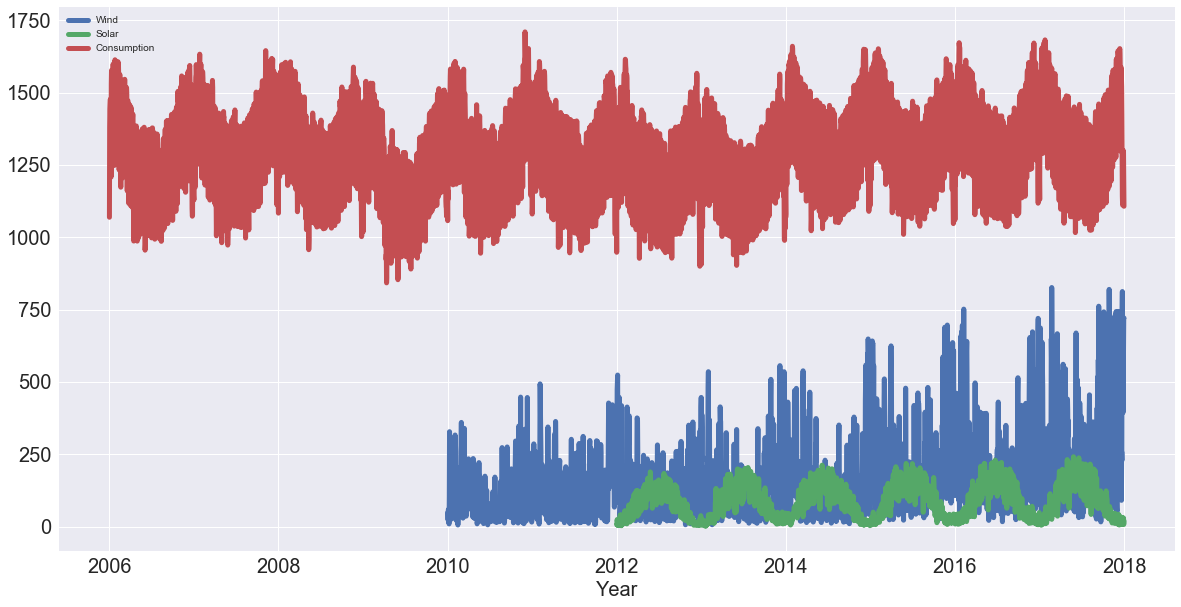

In [61]:
opsd_df[["Wind", "Solar", "Consumption"]].plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.xlabel('Year', fontsize=20);

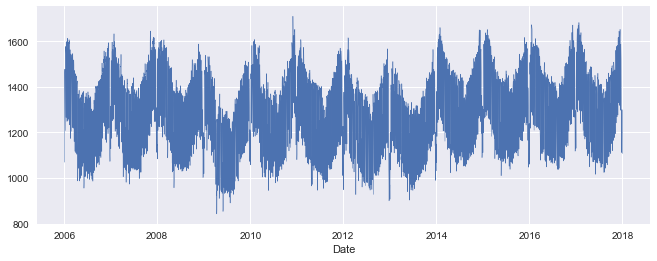

In [62]:
# it's a bit more clear with just one variable at a time
opsd_df['Consumption'].plot(linewidth=0.5)

We can spots some overall trends in the shape of the data and see that it's not random, but it could likely contain some seasonality or be cyclic. 

Let's pull out the data points in a scatterplot to decrease the density of information: 

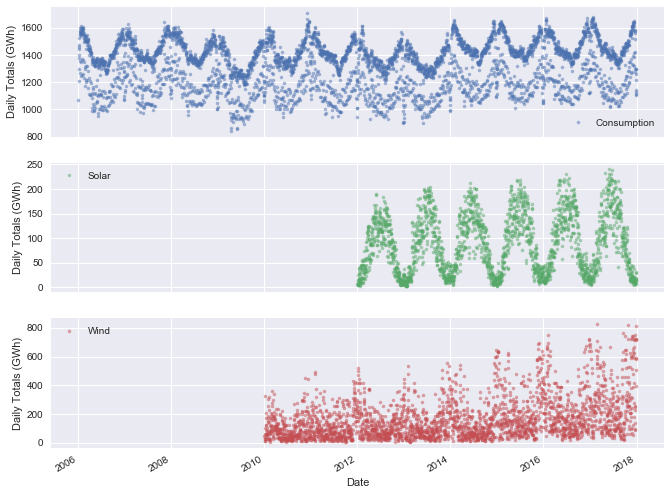

In [51]:
cols_plot = ['Consumption', 'Solar', 'Wind'] # select columns to plot
axes = opsd_df[cols_plot].plot(marker='.', # mark with points
                               alpha=0.5, # amount of transparency applied
                               linestyle='None', # add lines? 
                               figsize=(11, 9), 
                               subplots=True) # plot together
for ax in axes:
    ax.set_ylabel('Daily Totals (GWh)') # set axis labels

We can start seeing some trends in the data above: 
- Electricity consumption has peaks and falls every year. Presumably during heating and cooling season, we will need to look at this in more detail. 
- Solar power also shows some seasonal effect, patterns of similar highs and lows (peaks and troughs)
- Wind power shows an steady increase in consumption since 2010. We could examine changes in laws or regional rebates, as well as technological advances that could have started this upward trend. 

### Examining seasonlity
To get a better look at the potential seasonal effect in electricity consumption, we'll pull out just one year's worth of data and take a closer look: 

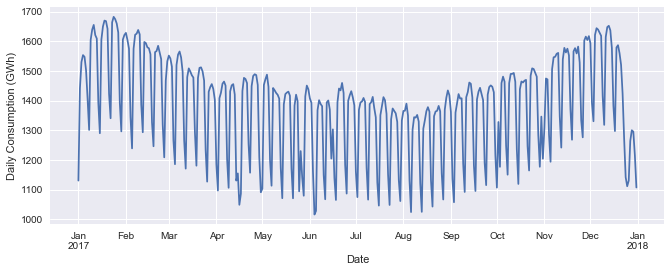

In [57]:
ax = opsd_df.loc['2017', 'Consumption'].plot()
ax.set_ylabel('Daily Consumption (GWh)');

And now it's much easier to see that heating in winter season has a very seasonal effect. Perhaps Germany doesn't get cool enough to use a lot of AC in the summertime? 

We can pull out just one month's worth of data to examine whether consumption is higher or lower on weekends or weekdays: 

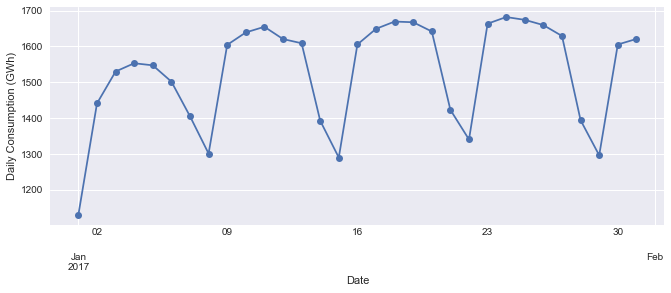

In [59]:
ax = opsd_df.loc['2017-01', 'Consumption'].plot(marker='o', linestyle='-')
ax.set_ylabel('Daily Consumption (GWh)');

The cycles show a cyclical rise on the weekedays and fall on the weekends.